## Will Millennials Ever Get Married?

This notebook contains analysis related to a paper on marriage patterns in the U.S., based on data from the National Survey of Family Growth (NSFG).

It is based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot
from thinkstats2 import Cdf

import survival
import marriage

SyntaxError: invalid syntax (<ipython-input-1-7bbe3fdba535>, line 15)

In [2]:
%time df = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
df.shape

Wall time: 223 ms


(64042, 41)

Make a table showing the number of respondents in each cycle:

In [3]:
df.cycle.value_counts().sort_index()

3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
Name: cycle, dtype: int64

In [4]:
def format_date_range(array):
    a, b = array.astype(int)
    return '%d--%d' % (a, b)

def SummarizeCycle(cycle, df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900
    
    intvw_dates = format_date_range(intvws)
    birth_dates = format_date_range(births)
    
    print(cycle, ' & ', intvw_dates, '&', len(df), '&', birth_dates, r'\\')

In [5]:
for cycle, group in df.groupby('cycle'):
    SummarizeCycle(cycle, group)

3  &  1982--1983 & 7969 & 1937--1968 \\
4  &  1988--1988 & 8450 & 1943--1973 \\
5  &  1995--1995 & 10847 & 1950--1980 \\
6  &  2002--2003 & 7643 & 1957--1988 \\
7  &  2006--2010 & 12279 & 1961--1995 \\
8  &  2011--2013 & 5601 & 1966--1998 \\
9  &  2013--2015 & 5699 & 1968--2000 \\
10  &  2015--2017 & 5554 & 1966--2002 \\


Check for missing values in `agemarry`:

In [52]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for cycle, group in df.groupby('cycle'):
    CheckAgeVars(group)

0
22
0
37
16
17
11
0


Generate a table with the number of respondents in each cohort:

In [6]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    age_range = '%d--%d' % (int(group.age.min()), int(group.age_index.max()))
    print(name, '&', len(group), '&', age_range,
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42--45 & 310 & 0 \\
40 & 3608 & 32--45 & 3287 & 9 \\
50 & 10631 & 22--45 & 8667 & 18 \\
60 & 14951 & 15--50 & 8813 & 33 \\
70 & 15016 & 14--47 & 8075 & 30 \\
80 & 12397 & 14--37 & 4208 & 13 \\
90 & 6695 & 15--27 & 517 & 0 \\
100 & 419 & 15--17 & 0 & 0 \\


In [7]:
def ComputeCutoffs(df):
    grouped = df.groupby('birth_index')
    cutoffs = {}
    for name, group in sorted(grouped):
        cutoffs[name] = int(group.age.max())
    return cutoffs

In [8]:
cutoffs = ComputeCutoffs(df)
cutoffs

{30: 45, 40: 45, 50: 45, 60: 50, 70: 47, 80: 37, 90: 27, 100: 17}

Estimate the hazard function for the 80s cohort (curious to see what's going on during the "marriage strike")

In [9]:
cohort = grouped.get_group(80)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	12384	1	0	8.1e-05
11	12383	1	0	8.1e-05
12	12382	1	0	8.1e-05
13	12381	10	0	0.00081
14	12371	12	14	0.00097
15	12345	40	260	0.0032
16	12045	104	242	0.0086
17	11699	152	338	0.013
18	11209	345	460	0.031
19	10404	436	569	0.042
20	9399	440	579	0.047
21	8380	426	572	0.051
22	7382	452	572	0.061
23	6358	383	454	0.06
24	5521	370	533	0.067
25	4618	317	576	0.069
26	3725	233	554	0.063
27	2938	167	506	0.057
28	2265	128	423	0.057
29	1714	76	391	0.044
30	1247	44	280	0.035
31	923	34	261	0.037
32	628	10	222	0.016
33	396	9	144	0.023
34	243	2	101	0.0082
35	140	1	72	0.0071
36	67	1	51	0.015
37	15	0	15	0


Run the same analysis for the 70s cohort (to extract $\lambda(33)$).

In [10]:
cohort = grouped.get_group(70)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	14986	2	0	0.00013
11	14984	1	0	6.7e-05
12	14983	4	0	0.00027
13	14979	11	0	0.00073
14	14968	38	3	0.0025
15	14927	81	388	0.0054
16	14458	181	518	0.013
17	13759	275	540	0.02
18	12944	562	340	0.043
19	12042	656	268	0.054
20	11118	635	242	0.057
21	10241	672	220	0.066
22	9349	702	264	0.075
23	8383	673	347	0.08
24	7363	611	345	0.083
25	6407	538	205	0.084
26	5664	481	149	0.085
27	5034	359	164	0.071
28	4511	373	198	0.083
29	3940	294	215	0.075
30	3431	235	315	0.068
31	2881	158	278	0.055
32	2445	138	212	0.056
33	2095	97	155	0.046
34	1843	78	173	0.042
35	1592	61	216	0.038
36	1315	34	203	0.026
37	1078	30	186	0.028
38	862	19	169	0.022
39	674	15	142	0.022
40	517	11	103	0.021
41	403	6	104	0.015
42	293	8	90	0.027
43	195	3	77	0.015
44	115	2	53	0.017
45	60	1	28	0.017
46	31	0	21	0
47	10	0	10	0


Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function directly.

[ 9.93846154e-01  9.69230769e-01  9.47692308e-01  9.01538462e-01
  8.18461538e-01  6.86153846e-01  5.60000000e-01  4.64615385e-01
  3.63076923e-01  2.95384615e-01  2.61538462e-01  2.33846154e-01
  2.12307692e-01  1.75384615e-01  1.47692308e-01  1.32307692e-01
  1.10769231e-01  1.01538462e-01  8.92307692e-02  7.69230769e-02
  7.38461538e-02  6.46153846e-02  6.15384615e-02  5.84615385e-02
  5.53846154e-02  4.92307692e-02  4.61538462e-02 -2.22044605e-16]


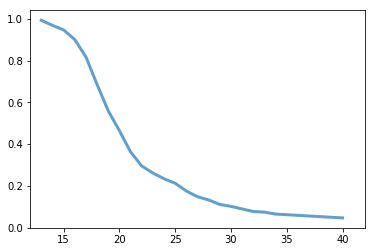

In [11]:
cohort = grouped.get_group(30)
sf = survival.MakeSurvivalFromSeq(cohort.agemarry_index.fillna(np.inf))
ts, ss = sf.Render()
print(ss)
thinkplot.Plot(ts, ss)
thinkplot.Config(xlim=[12, 42])

Then use the SurvivalFunction to compute the HazardFunction:

[0.00615385 0.0247678  0.02222222 0.0487013  0.09215017 0.16165414
 0.1838565  0.17032967 0.21854305 0.18644068 0.11458333 0.10588235
 0.09210526 0.17391304 0.15789474 0.10416667 0.1627907  0.08333333
 0.12121212 0.13793103 0.04       0.125      0.04761905 0.05
 0.05263158 0.11111111 0.0625     1.        ]


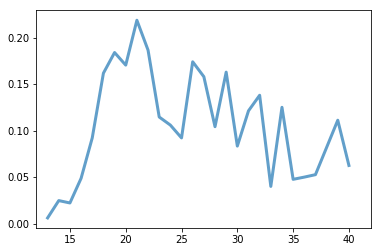

In [12]:
hf = sf.MakeHazardFunction()
ts, lams = hf.Render()
print(lams)
thinkplot.Plot(ts, lams)
thinkplot.Config(xlim=[12, 42])

Make the first figure, showing sf and hf for the 30s cohort:

In [13]:
options = dict(formats=['pdf', 'png'], clf=False)

Writing figs/marriage1.pdf
Writing figs/marriage1.png


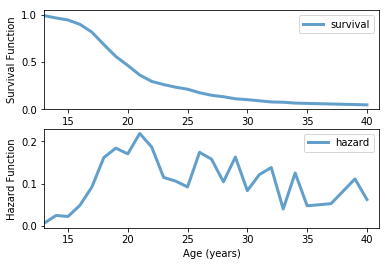

In [14]:
thinkplot.PrePlot(rows=2)

thinkplot.Plot(sf, label='survival')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.ylabel('Survival Function')

thinkplot.SubPlot(2)
thinkplot.Plot(hf, label='hazard')
thinkplot.Config(xlabel='age(years)', ylabel='Hazard function', xlim=[13, 41])
plt.ylabel('Hazard Function')
plt.xlabel('Age (years)')

thinkplot.Save(root='figs/marriage1', **options)

Writing figs/marriage2.pdf
Writing figs/marriage2.png


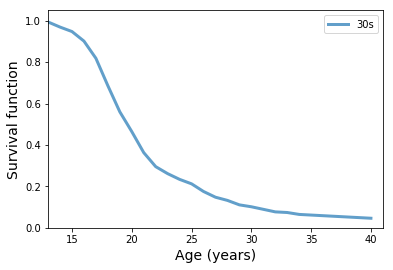

In [15]:
thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Survival function', fontsize=14)

thinkplot.Save(root='figs/marriage2', **options)

Writing figs/marriage3.pdf
Writing figs/marriage3.png


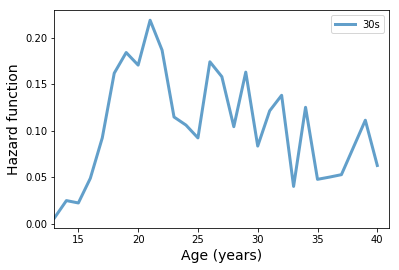

In [16]:
thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlim=[13, 41])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Hazard function', fontsize=14)

thinkplot.Save(root='figs/marriage3', **options)

Make some pivot tables, just to see where the data are:

In [17]:
pt = df.pivot_table(index='birth_index', columns='age_index', values='age', aggfunc=len, fill_value=0)
pt

age_index,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,19,146,148,12,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,414,384,194,198,25,0,0,0,0,0
50,0,0,0,0,0,0,0,0,42,301,...,371,482,633,533,38,0,0,0,0,0
60,0,269,300,370,665,722,609,513,520,242,...,562,537,512,517,33,18,83,153,137,2
70,3,389,523,549,362,293,283,285,365,572,...,430,363,332,241,129,116,38,0,0,0
80,14,260,242,340,483,589,658,683,705,602,...,0,0,0,0,0,0,0,0,0,0
90,0,749,829,895,888,737,452,514,465,392,...,0,0,0,0,0,0,0,0,0,0
100,0,181,171,67,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following pivot table is not as helpful as it could be, since it doesn't show the number at risk.

In [18]:
df.pivot_table(index='birth_index', columns='agemarry_index', values='age', aggfunc=len, fill_value=0)

agemarry_index,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,2,8,7,15,27,43,41,...,0,2,1,0,0,0,0,0,0,0
40,1,0,0,5,31,87,163,218,425,467,...,3,9,3,1,0,0,0,0,0,0
50,0,0,1,10,50,125,384,642,1111,1057,...,12,11,7,4,4,4,0,0,0,0
60,0,1,2,8,40,128,300,445,860,831,...,24,24,18,13,11,5,2,3,1,1
70,2,1,4,11,38,81,181,276,562,656,...,19,15,11,6,8,3,2,1,0,0
80,1,1,1,10,12,40,104,152,345,436,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,2,6,15,49,86,92,...,0,0,0,0,0,0,0,0,0,0


Estimate the survival curve for each cohort:

In [19]:
df['complete'] = df.evrmarry
df['complete_var'] = df.agemarry_index
df['ongoing_var'] = df.age_index
df['complete_missing'] = df.complete & df.complete_var.isnull()
df['ongoing_missing'] = ~df.complete & df.ongoing_var.isnull()

In [20]:
# for some marriages, we don't have the date of marriage

for cycle, group in df.groupby('cycle'):
    print(cycle, sum(group.complete_missing), sum(group.ongoing_missing))

3 0 0
4 22 0
5 0 0
6 37 0
7 16 0
8 17 0
9 11 0
10 0 0


In [21]:
resps = [group for cycle, group in df.groupby('cycle')]
# iters = 101
iters = 11

In [22]:
%time sf_map = marriage.EstimateSurvivalByCohort(resps, iters=iters, cutoffs=cutoffs)

Wall time: 2.03 s


In [23]:
del sf_map[30]

try: 
    del sf_map[100]
except KeyError:
    pass

Check a sample:

In [24]:
for sf in sf_map[90]:
    print(sf.ss)
    print(sf.Prob(34))
    break

14.0    0.999681
15.0    0.998723
16.0    0.997109
17.0    0.987191
18.0    0.965843
19.0    0.939526
20.0    0.905958
21.0    0.879493
22.0    0.844491
23.0    0.812266
24.0    0.775896
25.0    0.764316
26.0    0.764316
dtype: float64
0.7643155079315481


In [25]:
for sf in sf_map[80]:
    print(sf.ss)
    print(sf.Prob(34))
    break

10.0    0.999915
11.0    0.999660
13.0    0.998809
14.0    0.998044
15.0    0.993955
16.0    0.986987
17.0    0.974581
18.0    0.942401
19.0    0.902926
20.0    0.865593
21.0    0.815632
22.0    0.760069
23.0    0.706092
24.0    0.649355
25.0    0.586096
26.0    0.531331
27.0    0.483697
28.0    0.444862
29.0    0.416488
30.0    0.399811
31.0    0.382231
32.0    0.373702
33.0    0.350507
34.0    0.350507
35.0    0.350507
36.0    0.350507
dtype: float64
0.3505069037140526


Make the figure showing estimated survival curves:

In [26]:
def PlotSurvivalFunctions(root, sf_map, sf_map_pred=None, **options):

    if sf_map_pred:
        marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)
    marriage.PlotSurvivalFunctions(sf_map)

    thinkplot.config(xlabel='Age (years)',
                     ylabel='Fraction never married',
                     xlim=[13, 50], 
                     ylim=[0, 1.05], 
                     loc='upper right', 
                     frameon=False,
                     **options)
    plt.tight_layout()
    thinkplot.save(root=root, formats=['pdf', 'png'])

In [27]:
def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.
    
    args, kwds: same as for sns.color_palette
    
    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.
    
    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)
    
    palette = list(palette)
    if reverse:
        palette.reverse()
        
    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

In [28]:
def draw_age_lines(ages):
    for age in ages:
        plt.axvline(age, color='gray', linestyle='dotted', alpha=0.3)

Writing figs/marriage4.pdf
Writing figs/marriage4.png


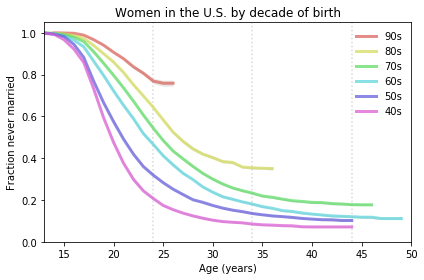

In [29]:
ages = [24, 34, 44]
palette = set_palette('hls', 6)
draw_age_lines(ages)
options_w = dict(title='Women in the U.S. by decade of birth')
PlotSurvivalFunctions('figs/marriage4', sf_map, None, **options_w)

Make a table of marriage rates for each cohort at each age:

In [30]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

In [31]:
def MakePercentageTable(sf_map, ages):
    """Prints percentage unmarried for each cohort at each age.
    """
    t = MakeTable(sf_map, ages)
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')
        
ages = [24, 34, 44]
MakePercentageTable(sf_map, ages=ages)

40 & 21 & 8 & 7 \\
50 & 32 & 14 & 10 \\
60 & 47 & 18 & 12 \\
70 & 54 & 23 & 18 \\
80 & 64 & 35 & nan \\
90 & 77 & nan & nan \\


Generate projections:

In [32]:
%time sf_map_pred = marriage.EstimateSurvivalByCohort(resps, iters=iters, cutoffs=cutoffs, predict_flag=True)
del sf_map_pred[30]

try: 
    del sf_map[100]
except KeyError:
    pass

Wall time: 2.07 s


In [33]:
for cohort, seq in sf_map_pred.items():
    if cohort > 90:
        break
    medians = [sf.MakeCdf().Value(0.5) for sf in seq]
    print(cohort, np.median(medians))

40 20.0
50 21.0
60 24.0
70 25.0
80 27.0
90 37.0


And make the figure showing projections:

Writing figs/marriage5.pdf
Writing figs/marriage5.png


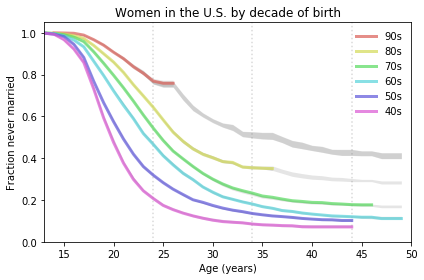

In [34]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
PlotSurvivalFunctions('figs/marriage5', sf_map, sf_map_pred, **options_w)

Make the table again with the projections filled in.

In [35]:
MakePercentageTable(sf_map_pred, ages)

40 & 21 & 9 & 8 \\
50 & 32 & 14 & 10 \\
60 & 47 & 18 & 12 \\
70 & 55 & 23 & 18 \\
80 & 64 & 36 & 30 \\
90 & 77 & 52 & 43 \\
100 & 77 & 52 & 43 \\


In [36]:
def PlotFractions(sf_map, ages, label_flag=False, **options):
    t = MakeTable(sf_map, ages)
    cohorts, cols = zip(*t)
    rows = zip(*cols)

    thinkplot.PrePlot(3)
    t = list(zip(ages, rows))
    for age, row in reversed(t):
        label = 'at age %d' % age if label_flag else ''
        thinkplot.Plot(cohorts, row, label=label, **options)

Writing figs/marriage6.pdf
Writing figs/marriage6.png


C:\Miniconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


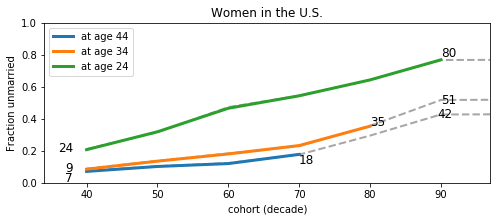

In [37]:
PlotFractions(sf_map_pred, ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map, ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(36, 0.26, '24', fontsize=fontsize)
thinkplot.Text(37, 0.13, '9', fontsize=fontsize)
thinkplot.Text(37, 0.07, '7', fontsize=fontsize)

thinkplot.Text(90, 0.85, '80', fontsize=fontsize)
thinkplot.Text(90, 0.56, '51', fontsize=fontsize)
thinkplot.Text(89.5, 0.47, '42', fontsize=fontsize)

thinkplot.Text(80, 0.42, '35', fontsize=fontsize)
thinkplot.Text(70, 0.18, '18', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='upper left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Women in the U.S.')

thinkplot.Save(root='figs/marriage6', **options)

## Marriage patterns for men

In [38]:
%time df2 = pd.read_hdf('MaleMarriageData.hdf', 'MaleMarriageData')
df2.shape

Wall time: 19.9 ms


(29192, 37)

In [39]:
for cycle, group in df2.groupby('cycle'):
    SummarizeCycle(cycle, group)

6  &  2002--2003 & 4928 & 1957--1988 \\
7  &  2006--2010 & 10403 & 1961--1995 \\
8  &  2011--2013 & 4815 & 1966--1998 \\
9  &  2013--2015 & 4506 & 1968--2000 \\
10  &  2015--2017 & 4540 & 1965--2002 \\


In [40]:
sum(df2.missing)

0

In [41]:
marriage.DigitizeResp(df2)
grouped = df2.groupby('birth_index')
for name, group in iter(grouped):
    age_range = '%d--%d' % (int(group.age.min()), int(group.age_index.max()))
    print(name, '&', len(group), '&', age_range,
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

50 & 322 & 42--45 & 224 & 0 \\
60 & 3970 & 32--50 & 2755 & 0 \\
70 & 8282 & 22--47 & 4883 & 0 \\
80 & 9861 & 15--37 & 2445 & 0 \\
90 & 6364 & 15--27 & 243 & 0 \\
100 & 393 & 15--17 & 0 & 0 \\


In [42]:
cutoffs2 = ComputeCutoffs(df2)
cutoffs2

{50: 45, 60: 50, 70: 47, 80: 37, 90: 27, 100: 17}

In [43]:
resps2 = [group for cycle, group in df2.groupby('cycle')]

In [44]:
%time sf_map_male = marriage.EstimateSurvivalByCohort(resps2, iters=iters, cutoffs=cutoffs2)
del sf_map_male[100]

Wall time: 954 ms


Writing figs/marriage7.pdf
Writing figs/marriage7.png


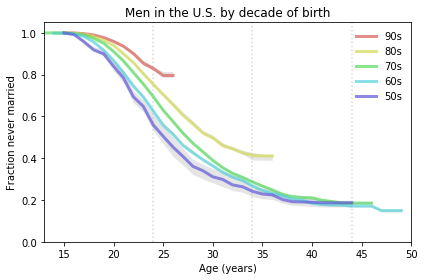

In [45]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
options_m = dict(title='Men in the U.S. by decade of birth')
PlotSurvivalFunctions('figs/marriage7', sf_map_male, None, **options_m)

In [46]:
%time sf_map_male_pred = marriage.EstimateSurvivalByCohort(resps2, iters=iters, cutoffs=cutoffs2, predict_flag=True)
del sf_map_male_pred[100]

Wall time: 976 ms


In [47]:
for cohort, seq in sf_map_male_pred.items():
    if cohort > 90:
        break
    medians = [sf.MakeCdf().Value(0.5) for sf in seq]
    print(cohort, np.median(medians))

50 26.0
60 27.0
70 28.0
80 30.0
90 35.0


Writing figs/marriage8.pdf
Writing figs/marriage8.png


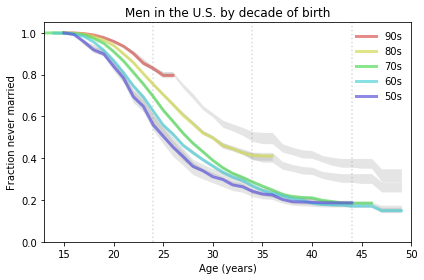

In [48]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
PlotSurvivalFunctions('figs/marriage8', sf_map_male, sf_map_male_pred, **options_m)

In [49]:
MakePercentageTable(sf_map_male, ages)

50 & 56 & 24 & 19 \\
60 & 63 & 27 & 17 \\
70 & 70 & 29 & 18 \\
80 & 75 & 41 & nan \\
90 & 83 & nan & nan \\


In [50]:
MakePercentageTable(sf_map_male_pred, ages)

50 & 58 & 24 & 18 \\
60 & 62 & 27 & 18 \\
70 & 69 & 28 & 19 \\
80 & 75 & 41 & 31 \\
90 & 83 & 51 & 37 \\


Writing figs/marriage9.pdf
Writing figs/marriage9.png


C:\Miniconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


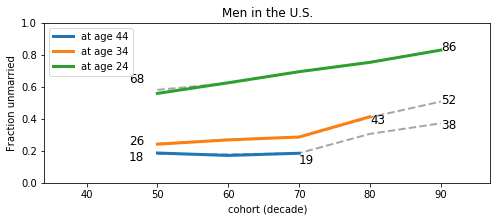

In [51]:
PlotFractions(sf_map_male_pred, ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map_male, ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(46, 0.69, '68', fontsize=fontsize)
thinkplot.Text(46, 0.30, '26', fontsize=fontsize)
thinkplot.Text(46, 0.20, '18', fontsize=fontsize)

thinkplot.Text(70, 0.18, '19', fontsize=fontsize)

thinkplot.Text(80, 0.43, '43', fontsize=fontsize)

thinkplot.Text(90, 0.89, '86', fontsize=fontsize)
thinkplot.Text(90, 0.56, '52', fontsize=fontsize)
thinkplot.Text(90, 0.40, '38', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='upper left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Men in the U.S.')

thinkplot.Save(root='figs/marriage9', **options)